In [1]:
import torch
import torchvision 
import torchvision.datasets as datasets
import torchvision.transforms as T
import numpy as np
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

from skimage.segmentation import slic
import skimage as ski

In [2]:
ds = datasets.CIFAR10(root="cifar10/test", train=False, download=True, transform=T.ToTensor())

Files already downloaded and verified


In [3]:
from compute_features import color_features

In [1]:
img_np = ds[7][0]
img_np = torch.stack([img_np[0], img_np[1], img_np[2]], dim=2).numpy()
print(img_np.shape)
n_segments = 5
compactness = 0.1
s = slic(img_np, n_segments, compactness, start_label=0)
# plt.imshow(ski.segmentation.mark_boundaries(img_np, s, mode='subpixel'))
a = color_features(img_np)

NameError: name 'ds' is not defined

In [6]:
i,j = 10,10
0.5*(np.max(img_np[i][j]) + np.min(img_np[i][j]))

0.17843137681484222

In [7]:
n_segments = 10
compactness = 0.1

# features 
get_avg_color = True
get_std_deviation_color = True
get_centroid = True
get_std_deviation_centroid = True
get_num_pixels = False

feature_mask = np.ones(17, dtype=np.bool8)

In [8]:
    img, y = d
    _, dim0, dim1 = img.shape
    img_np = torch.stack([img[0], img[1], img[2]], dim=2).numpy()
    if self.get_hsv:
        img_hsv = rgb2hsv(img_np)
    s = slic(img_np, self.n_segments, self.compactness, start_label=0)
    # rag_mean_color() fails when image is segmented into 1 superpixel 
    if np.any(s):
        g = ski.future.graph.rag_mean_color(img_np, s)
        n = g.number_of_nodes()
        edge_index = torch.from_numpy(np.array(g.edges).T).to(torch.long)
    else: 
        n = 1
        edge_index = torch.tensor([]).to(torch.long)
    s1 = np.zeros([n, 3])  # for mean color and std deviation
    s2 = np.zeros([n, 3])  # for std deviation
    if self.get_hsv:
        s1_hsv = np.zeros([n,3])
        s2_hsv = np.zeros([n,3])
    if self.get_lightness:
        s1_lightness = np.zeros([n,1])
        s2_lightness = np.zeros([n,1])
    pos1 = np.zeros([n, 2]) # for centroid
    pos2 = np.zeros([n, 2]) # for centroid std deviation
    num_pixels = np.zeros([n, 1])
    for idx in range(dim0 * dim1):
            idx_i, idx_j = idx % dim0, int(idx / dim0)
            node = s[idx_i][idx_j] - 1
            s1[node][0]  += img_np[idx_i][idx_j][0]
            s2[node][0]  += pow(img_np[idx_i][idx_j][0], 2)
            s1[node][1]  += img_np[idx_i][idx_j][1]
            s2[node][1]  += pow(img_np[idx_i][idx_j][1], 2)
            s1[node][2]  += img_np[idx_i][idx_j][2]
            s2[node][2]  += pow(img_np[idx_i][idx_j][2], 2)
            if self.get_hsv:
                s1_hsv[node][0]  += img_hsv[idx_i][idx_j][0]
                s2_hsv[node][0]  += pow(img_hsv[idx_i][idx_j][0], 2)
                s1_hsv[node][1]  += img_hsv[idx_i][idx_j][1]
                s2_hsv[node][1]  += pow(img_hsv[idx_i][idx_j][1], 2)
                s1_hsv[node][2]  += img_hsv[idx_i][idx_j][2]
                s2_hsv[node][2]  += pow(img_hsv[idx_i][idx_j][2], 2)
            if self.get_lightness:
                lightness = 0.5 * (np.max(img_np[idx_i][idx_j]) + np.min(img_np[idx_i][idx_j]))
                s1_lightness[node][0] += lightness
                s2_lightness[node][0] += pow(lightness, 2)
            pos1[node][0] += idx_i
            pos1[node][1] += idx_j
            pos2[node][0] += pow(idx_i, 2)
            pos2[node][1] += pow(idx_j, 2)
            num_pixels[node][0] += 1
    x = []
    if self.get_rgb:
        s1 = s1/num_pixels
        if self.get_avg_color:
            avg_color = torch.from_numpy(s1).to(torch.float)
            x.append(avg_color[:,0])
            x.append(avg_color[:,1])
            x.append(avg_color[:,2])
    if self.get_std_dev_color:
        s2 = s2/num_pixels
        std_dev = torch.from_numpy(np.sqrt(np.abs((s2 - s1*s1)))).to(torch.float)
        x.append(std_dev[:,0])
        x.append(std_dev[:,1])
        x.append(std_dev[:,2])
    if self.get_hsv:
        s1_hsv = s1_hsv/num_pixels
        if self.get_avg_color_hsv:
            avg_color_hsv = torch.from_numpy(s1_hsv).to(torch.float)
            x.append(avg_color_hsv[:,0])
            x.append(avg_color_hsv[:,1])
            x.append(avg_color_hsv[:,2])
        if self.get_std_dev_color_hsv:
            s2_hsv = s2_hsv/num_pixels
            std_dev_hsv = torch.from_numpy(np.sqrt(np.abs((s2_hsv - s1_hsv*s1_hsv)))).to(torch.float)
            x.append(std_dev_hsv[:,0])
            x.append(std_dev_hsv[:,1])
            x.append(std_dev_hsv[:,2])
    if self.get_lightness:
        s1_lightness = s1_lightness/num_pixels
        if self.get_avg_lightness:
            avg_lightness = torch.from_numpy(s1_lightness).to(torch.float)
            x.append(avg_lightness[:,0])
        if self.get_std_dev_lightness:
            s2_lightness = s2_lightness/num_pixels
            std_dev_lightness = torch.from_numpy(np.sqrt(np.abs((s2_lightness - s1_lightness*s1_lightness)))).to(torch.float)
            x.append(std_dev_lightness[:,0])
    pos1 = pos1/num_pixels
    pos = torch.from_numpy(pos1).to(torch.float)
    if self.get_centroid:
        x.append(pos[:,0])
        x.append(pos[:,1])
    if self.get_std_dev_centroid:
        pos2 = pos2/num_pixels
        std_dev_centroid = torch.from_numpy(np.sqrt(np.abs(pos2 - pos1*pos1))).to(torch.float)
        x.append(std_dev_centroid[:,0])
        x.append(std_dev_centroid[:,1])
    if self.get_num_pixels:
        x.append(torch.from_numpy(num_pixels.flatten()).to(torch.float))
    return Data(x=torch.stack(x, dim=1), edge_index=edge_index, pos=pos, y=y)

KeyError: 0

Grph with 6 nodes and 9 edges
Label: 3


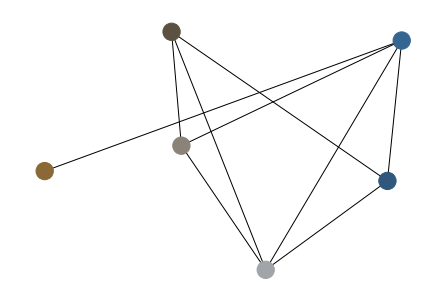

In [8]:
import networkx as nx
from torch_geometric.utils import to_networkx

print(f'Grph with {g.number_of_nodes()} nodes and {g.number_of_edges()} edges')
print(f'Label: {data.y}')
color = data.x[:,0:3]
pos = dict(zip(range(data.num_nodes), data.pos.numpy()))
nx.draw(g, pos=pos, node_color=color)

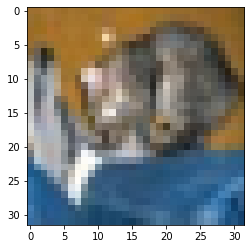

In [117]:
plt.imshow(img_np)

In [3]:
import cifar10_slic
from torch.utils.data import ConcatDataset, SubsetRandomSampler
spds_test = cifar10_slic.SuperPixelGraphCIFAR10(train=False,use_ext=True, features=['avg_color', 'std_deviation_color', 'centroid', 'std_deviation_centroid'])

Selected features: 
	+ avg_color
	+ std_deviation_color
	+ centroid
	+ std_deviation_centroid
CIFAR10 Loaded.
Average number of nodes: 118.6724 with standard deviation 4.085030996210433
Average number of edges: 218.9385 with standard deviation 2.571520513237256


In [4]:
data = spds_test[0]
print(data.x.shape)

torch.Size([120, 10])


In [26]:
y_train = torch.cat([d.y for d in spds_train])
y_test = torch.cat([d.y for d in spds_test])
y = torch.cat([y_train, y_test])

In [38]:
spds.datasets[0].features

['avg_color', 'centroid', 'std_deviation_centroid', 'std_deviation_color']

In [58]:
f1 = {'a': 1, 'b': 2}
f2 = {'a': 2, 'b': 3}
fs = [f1, f2]

g1 = {'a': 3, 'b': 4}
g2 = {'a': 4, 'b': 5}
gs = [g1, g2]

h = np.array([fs, gs])



(2, 2)


In [64]:
h = np.array(h)
ar = {}
for e in range(2):
    for field in ['a', 'b']:
        ar[field] = np.average([f[field] for f in h[:,e]])
    print(ar)


{'a': 2.0, 'b': 3.0}
{'a': 3.0, 'b': 4.0}


In [27]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)

In [35]:
s = skf.split(np.zeros(len(y)), y)
for i in s:
    print(i)

(array([11665, 11667, 11673, ..., 59997, 59998, 59999]), array([    0,     1,     2, ..., 12532, 12545, 12556]))
(array([    0,     1,     2, ..., 59997, 59998, 59999]), array([11665, 11667, 11673, ..., 24877, 24890, 24899]))
(array([    0,     1,     2, ..., 59997, 59998, 59999]), array([23618, 23628, 23630, ..., 36286, 36287, 36289]))
(array([    0,     1,     2, ..., 59997, 59998, 59999]), array([35673, 35677, 35681, ..., 48164, 48168, 48175]))
(array([    0,     1,     2, ..., 48164, 48168, 48175]), array([47664, 47716, 47735, ..., 59997, 59998, 59999]))


Grph with 227 nodes and 698 edges
Label: 0


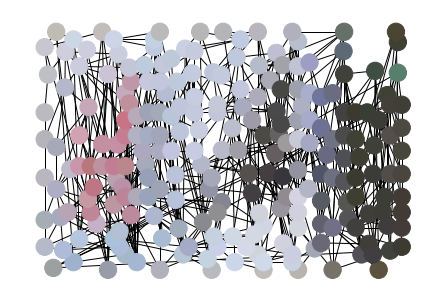

In [6]:

import networkx as nx
from torch_geometric.utils import to_networkx
data = spds[3]

g = to_networkx(data, to_undirected=True)
print(f'Grph with {g.number_of_nodes()} nodes and {g.number_of_edges()} edges')
print(f'Label: {data.y[0]}')
color = data.x[:,0:3]
pos = dict(zip(range(data.num_nodes), data.pos.numpy()))
nx.draw(g, pos=pos, node_color=color)